# Amazon Reviews Sentiment Analysis
 <p><strong>Hypothesis:</strong> does positive reviews lead to high rankings? & high sales? </p>
    does # of reviews lead to high rankings? 
<p><strong>Data Set:</strong> Amazon fashion vs Clothing, shoes and jewlery from 2014 - 2018 </p>

<p><strong> to do:</strong>
- need reviews sentiment and rankings (can use products with ranking)
- extract rankings (how to unlist cells with list?)

In [209]:
import re
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
# Dataframe
import pandas as pd
# Array
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline

# Datetime
from datetime import datetime

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Large dataset
import dask.bag as db

import string

from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
from nltk import word_tokenize
from nltk.corpus import stopwords
#import nltk
#nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evashuyuwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import os
os.getcwd()

'/Users/evashuyuwang/Desktop/DS_Prep_OA/DS4A/project'

In [3]:
# Load and convert compressed file to dataframe
def parse_gz(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def convert_to_DF(path):
    i = 0
    df = {}
    for d in parse_gz(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [12]:
meta_amzn = convert_to_DF('/Users/evashuyuwang/Downloads/meta_AMAZON_FASHION.json.gz')
#review_amzn = convert_to_DF('/Users/evashuyuwang/Downloads/AMAZON_FASHION.json.gz')
#meta_cjs = convert_to_DF('/Users/evashuyuwang/Downloads/meta_Clothing_Shoes_and_Jewelry.json.gz')

In [219]:
print(meta_amzn.shape)
meta_amzn.head(3)

(186627, 18)


,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
0,NaN,,[],,Dante's Peak - Laserdisc,[],[],,,"[<span class=""a-text-bold"">Package Dimensions:...","16,714,561 in Clothing, Shoes & Jewelry (",[],{},"<img src=""https://images-na.ssl-images-amazon....",,"<div class=""a-fixed-left-grid a-spacing-none"">...",,630456984X
1,NaN,,[],,Milliongadgets(TM) Earring Safety Backs For Fi...,[],[https://images-na.ssl-images-amazon.com/image...,,,"[<span class=""a-text-bold"">ASIN:\n ...","2,081,098 in Clothing, Shoes & Jewelry (",[],{},"<img src=""https://images-na.ssl-images-amazon....",,fishhook,,7106116521
2,NaN,,[Educating the next generation in the responsi...,,Envirosax Kids Series Jessie &amp; Lulu,[],[],,Envirosax,"[<span class=""a-text-bold"">Product Dimensions:...","25,698,912 in Clothing, Shoes & Jewelry (",[],{},"<img src=""https://images-na.ssl-images-amazon....",,"<div class=""a-fixed-left-grid a-spacing-none"">...",,8037200124


In [159]:
review = []
with gzip.open('/Users/evashuyuwang/Downloads/AMAZON_FASHION.json.gz') as f:
    for l in f:
        review.append(json.loads(l.strip()))
review_amzn_original = pd.DataFrame.from_dict(review)

In [ ]:
'''
review = []
with gzip.open('/Users/evashuyuwang/Downloads/Clothing_Shoes_and_Jewelry.json.gz') as f:
    for l in f:
        review.append(json.loads(l.strip()))
review_cjs = pd.DataFrame.from_dict(review)
'''

In [160]:
print(review_amzn_original.shape)
review_amzn_original.head()
review_amzn = review_amzn_original.copy()

(883636, 12)


In [141]:
review_amzn.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
style              object
image              object
dtype: object

## Data Preprocessing

In [161]:
review_amzn["reviewTime"] = pd.to_datetime(review_amzn["reviewTime"])
review_amzn = review_amzn[['asin', 'summary', 'reviewText', 'overall', 'verified','vote', 'reviewerID', 'reviewerName', 'reviewTime',
      'unixReviewTime']]
review_amzn.head()

,asin,summary,reviewText,overall,verified,vote,reviewerID,reviewerName,reviewTime,unixReviewTime
0,7106116521,perfect replacements!!,Exactly what I needed.,5.0,True,NaN,A1D4G1SNUZWQOT,Tracy,2014-10-20,1413763200
1,7106116521,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",2.0,True,3,A3DDWDH9PX2YX2,Sonja Lau,2014-09-28,1411862400
2,7106116521,My New 'Friends' !!,Love these... I am going to order another pack...,4.0,False,NaN,A2MWC41EW7XL15,Kathleen,2014-08-25,1408924800
3,7106116521,Two Stars,too tiny an opening,2.0,True,NaN,A2UH2QQ275NV45,Jodi Stoner,2014-08-24,1408838400
4,7106116521,Three Stars,Okay,3.0,False,NaN,A89F3LQADZBS5,Alexander D.,2014-07-27,1406419200


In [162]:
# set time range 2016 - 2018
import datetime
print(review_amzn.reviewTime.max())
print(review_amzn.reviewTime.min())
review_amzn = review_amzn[review_amzn.reviewTime > '2016-09-30 00:00:00']

2018-10-01 00:00:00
2002-11-11 00:00:00


In [231]:
print(review_amzn.reviewTime.max())
print(review_amzn.reviewTime.min())
review_amzn.shape

2018-10-01 00:00:00
2016-10-01 00:00:00


(303240, 10)

In [164]:
# number of unique products
products = review_amzn['overall'].groupby(review_amzn['asin']).count()
print("Number of Unique Products in the Amazon Category = {}".format(products.count()))

Number of Unique Products in the Amazon Category = 78888


### Meta data

In [42]:
print('number of records:',len(meta_amzn))
print('number of unique product id:',meta_amzn['asin'].nunique())

number of records: 186627
number of unique product id: 186184


In [43]:
meta_amzn.category= meta_amzn.category.apply(lambda y: np.nan if len(y)==0 else y)

In [ ]:
# extract rank from string, empty list as nan
meta_amzn['rank']= meta_amzn['rank'].apply(lambda y: np.nan if len(y)==0 else int(y[0].split()[0].replace(',','')))
#int(meta_amzn['rank'][0].split()[0].replace(',',''))

In [51]:
# all products don't have category label 
meta_amzn[meta_amzn.category.notnull()]

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin


In [56]:
meta_amzn.brand.head(200).unique()

array(['', 'Envirosax', 'Gifts by Lulee', 'Tideclothes', 'Roar Carbon',
       'Shimmer Anne Shine', 'SpongeBob SquarePants', 'PERLINA', 'Trager',
       'Southern Converters', 'J. P. Ourse & Cie.',
       'J. P. Ourse &amp; Cie.', 'Mountainsmith', 'e-Pak', 'PICNIC TIME',
       'Sumdex', 'Eastpak', 'La Regale', 'Lewis N. Clark', 'Clive',
       'RoadWired', 'Etienne Aigner', "Rolf's", 'U.S. Luggage',
       'Wally Bags', 'PDA Skins', 'Airplane', 'Dopp', 'Buxton', 'Olga',
       'Goddess', 'RIPS', 'Mansilk', 'Bianchi', 'A&amp;E Designs',
       'Silhouettes', 'Maui Jim', 'EyeSave', 'GoldenMine.com Jewelry',
       'Serengeti', 'Avelor Collection', 'Emma Jane', 'Innovative Scuba',
       'Fit-Overs', 'Guide Gear', 'Amazon Collection', 'Elder',
       'Amazon.com Collection', 'DXL', 'Harbor Bay',
       'MT. RUSHMORE BH GOLD', 'Roberto Villini', 'Girbaud', 'WileyX',
       'UrbanSpecs', 'Ray-Ban', 'Frank Bee', 'Logo Art', 'Aquapac',
       'Szul', 'OGIO', 'Raika', 'Kolpin', 'Oleg Cassini

In [87]:
meta_amzn[meta_amzn.brand == 'Ray-Ban'].shape

(35, 18)

In [88]:
meta_amzn[meta_amzn.title.notnull()].shape

(186627, 18)

- all products in amazon fashion don't have category labels
- only compare products in several brands?
- take ranking out first

In [89]:
int(meta_amzn['rank'][0].split()[0].replace(',',''))

16714561

In [91]:
type(meta_amzn['rank'][0])

str

## Reviews data - EDA

average ratings: 3.9613408521303257


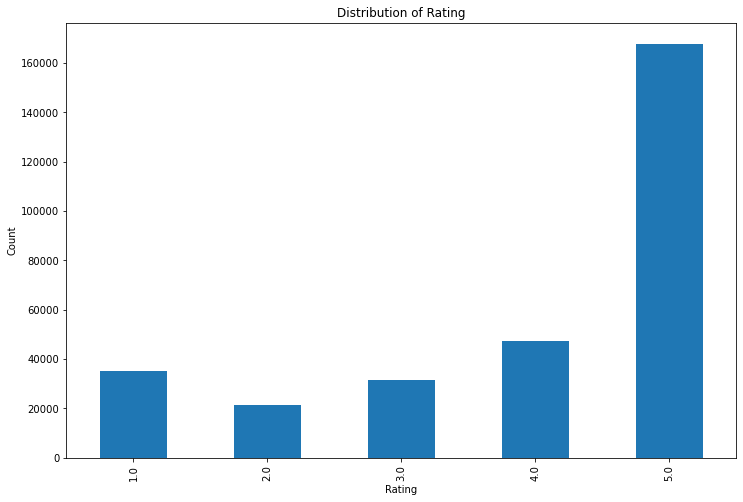

In [228]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
review_amzn['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
print('average ratings:',review_amzn['overall'].mean())

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

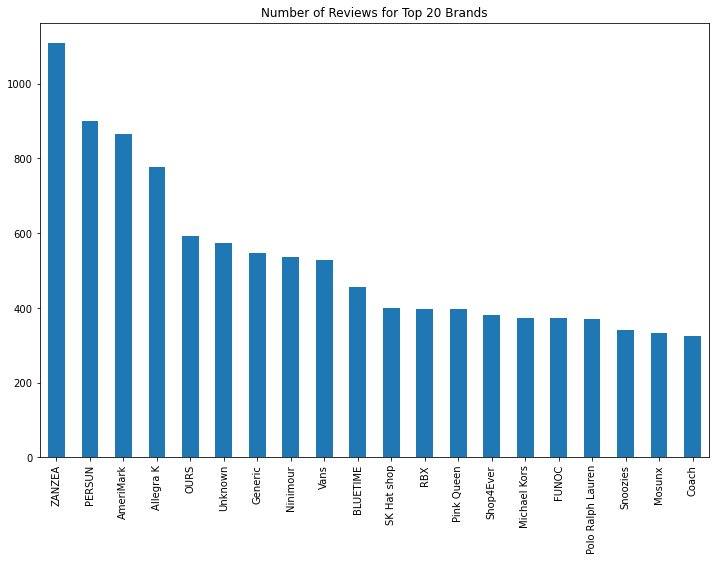

In [226]:
# Plot number of reviews for top 20 brands
brands = meta_amzn[meta_amzn.brand != '']["brand"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

Text(0, 0.5, 'Count')

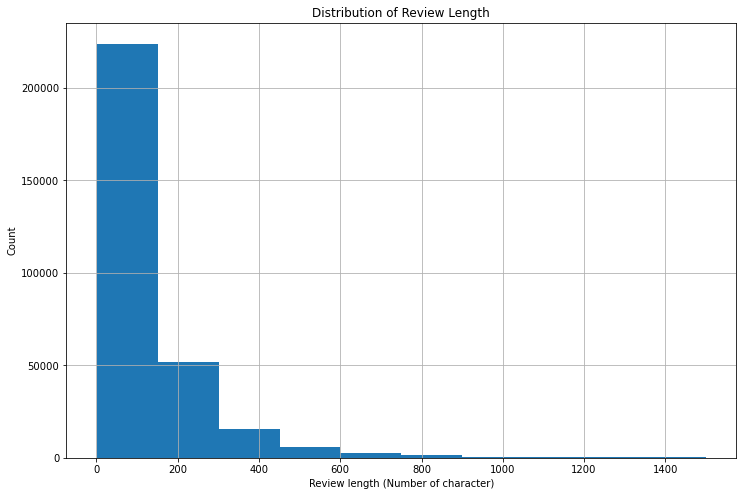

In [230]:
# Plot distribution of review length
review_length = review_amzn["reviewText"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

## Reviews data - data preparation for Modeling

In [165]:
#270k reviews in full reviews set 54k in sample set
review_amzn_sample= review_amzn.sample(frac=0.2, random_state=0) #uncomment to use full set of data
print(review_amzn_sample.shape)
# Drop missing values
review_amzn_sample.dropna(inplace=True)
print(review_amzn_sample.shape)

# Remove any 'neutral' ratings equal to 3
review_amzn_sample = review_amzn_sample[review_amzn_sample['overall'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
review_amzn_sample['Sentiment'] = np.where(review_amzn_sample['overall'] > 3, 1, 0)
review_amzn_sample.head()

(60648, 10)
(2896, 10)


,asin,summary,reviewText,overall,verified,vote,reviewerID,reviewerName,reviewTime,unixReviewTime,Sentiment
347324,B019Q577XC,... wore this dress for my birthday and it was...,I wore this dress for my birthday and it was P...,5.0,True,109,A1V9DJ5MQGMDQ,Amazon Customer,2016-10-03,1475452800,1
739894,B017LRSKZ6,"You get what you pay for... Garbage material, ...",This is complete garbage. Don't waste your mon...,1.0,True,2,A2RLSSA49ED3VP,t3j,2017-03-06,1488758400,0
845060,B01EUU5MYY,Five Stars,Love how it fits!,4.0,False,2,A1IV3B1Y8CP2FB,Amazon Customer,2017-02-11,1486771200,1
50834,B001T4MSU6,but I am so glad I bought this and used it pos...,Sizing worked perfectly as described. This was...,5.0,True,2,A6WT4NUM7ZG8W,Amazon Customer,2017-05-22,1495411200,1
339166,B0187MPCPA,The front on the shirt is like a breezy stretc...,The front on the shirt is like a breezy stretc...,5.0,True,3,A2RBP2SJKH17O,Amazon Customer,2016-12-06,1480982400,1


In [166]:
print(review_amzn_sample.shape)
print(review_amzn_sample.asin.nunique())

(2576, 11)
1780


In [168]:
# merge meta with review
df = pd.merge(review_amzn_sample,meta_amzn,on='asin',how = 'left')

In [169]:
df = df.drop(columns =['details', 'tech2','details','main_cat','similar_item','date','price']) 
print(df.shape)
df.head(5)

(2578, 22)


,asin,summary,reviewText,overall,verified,vote,reviewerID,reviewerName,reviewTime,unixReviewTime,...,tech1,description,fit,title,also_buy,image,brand,feature,rank,also_view
0,B019Q577XC,... wore this dress for my birthday and it was...,I wore this dress for my birthday and it was P...,5.0,True,109,A1V9DJ5MQGMDQ,Amazon Customer,2016-10-03,1475452800,...,,[<b>Basic Information:</b><br>Kearia dress is ...,"class=""a-normal a-align-center a-spacing-smal...",Kearia Women Short Sleeve Deep V-Neck Sequin S...,"[B00J3BRLOA, B01JY44XC8, B01HSYK71C, B07H872TT...",[https://images-na.ssl-images-amazon.com/image...,Kearia,[High quality blend fabric keeps you comfortab...,"9,850 in Clothing, Shoes & Jewelry (","[B00LZRGRA4, B01HSYK71C, B0762KVCNR, B01HR6ZW2..."
1,B017LRSKZ6,"You get what you pay for... Garbage material, ...",This is complete garbage. Don't waste your mon...,1.0,True,2,A2RLSSA49ED3VP,t3j,2017-03-06,1488758400,...,,[],,ROPALIA Teen Girl's Casual Crew Neck Sweatshir...,"[B07JM43GCB, B01MSQP50G, B07K3SXK96, B07CM6JV6...",[https://images-na.ssl-images-amazon.com/image...,ROPALIA,"[<span class=""a-text-bold"">ASIN:\n ...","1,253,733 in Clothing, Shoes & Jewelry (",[]
2,B01EUU5MYY,Five Stars,Love how it fits!,4.0,False,2,A1IV3B1Y8CP2FB,Amazon Customer,2017-02-11,1486771200,...,,[],,Fllbridal Women's Beaded Sweetheart Lace up Me...,[],[https://images-na.ssl-images-amazon.com/image...,Fllbridal,"[<span class=""a-text-bold"">Package Dimensions:...","6,000,519 in Clothing, Shoes & Jewelry (",[]
3,B001T4MSU6,but I am so glad I bought this and used it pos...,Sizing worked perfectly as described. This was...,5.0,True,2,A6WT4NUM7ZG8W,Amazon Customer,2017-05-22,1495411200,...,,"[Sometimes, keepin it real is about keepin it ...","class=""a-normal a-align-center a-spacing-smal...",Belly Bandit Original Postpartum Belly Wrap,"[B00VO65XB0, B078GBD9CL, B07C8ZZJLN, B0779BF4V...",[https://images-na.ssl-images-amazon.com/image...,,"[75% Polyester, 25% Lycra, Original basic bell...","13,861 in Clothing, Shoes & Jewelry (","[B07JGSG2RW, B07C5C9SRQ, B07C8ZZJLN, B078GBD9C..."
4,B0187MPCPA,The front on the shirt is like a breezy stretc...,The front on the shirt is like a breezy stretc...,5.0,True,3,A2RBP2SJKH17O,Amazon Customer,2016-12-06,1480982400,...,,[Pink Queen Womens 3d Cartoon Print Long Sleev...,"class=""a-normal a-align-center a-spacing-smal...",Fashion-Plus New Style Men's Lion King 3D Prin...,"[B01K1NE81C, B01N2NJLUV, B01ND15GVO, B07CDW71R...",[https://images-na.ssl-images-amazon.com/image...,Fashion-Plus,"[100% Brand New, material: Cotton and Poly, Pr...","641,954 in Clothing, Shoes & Jewelry (","[B01K1NE81C, B06XVQ12VY, B07BMJ7GM1, B07BQD8N6..."


In [243]:
# extract rank from string, empty list as nan
#df['rank'][:20].apply(lambda y: np.nan if len(y)==0 else int(y.split()[0].replace(',','')))
df['rank'][:10].apply(lambda y: len(y))
#df['rank']= df['rank'].apply(lambda y: np.nan if len(y)==0 else int(y[0].split()[0].replace(',','')))

0    36
1    40
2    40
3    37
4    38
5    38
6    36
7    38
8    38
9    40
Name: rank, dtype: int64

In [171]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 2320 training examples and 258 validation examples. 

Show a review in the training set : 
 It's pretty big and although I like the ability to get the neckless bigger or smaller ... I would have like it to be of a different material.  I had a friend translate what the coin meant ushering in wealth and prosperity (idiom and traditional greeting, esp. at New Year)
Interjection Edit


let riches and treasures come into the house


In [172]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [173]:
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 it s pretty big and although i like the ability to get the neckless bigger or smaller i would have like it to be of a different material i had a friend translate what the coin meant ushering in wealth and prosperity idiom and traditional greeting esp at new year interjection edit let riches and treasures come into the house


### Wordcloud
In this section, we create word clouds for positive sentiment reviews and negative sentiment reviews of Amazon fashion products to get an intuition of words frequently appear in different sentiments.

In [194]:
def create_word_cloud(brand, sentiment):
    #try: 
        #df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand = df
        df_brand_sample = df_brand.sample(frac= 1)
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["reviewText"]
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["reviewText"]
            
        for val in df_reviews.str.lower():
            tokens = word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        print(wordcloud)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    #except: 
    #    pass

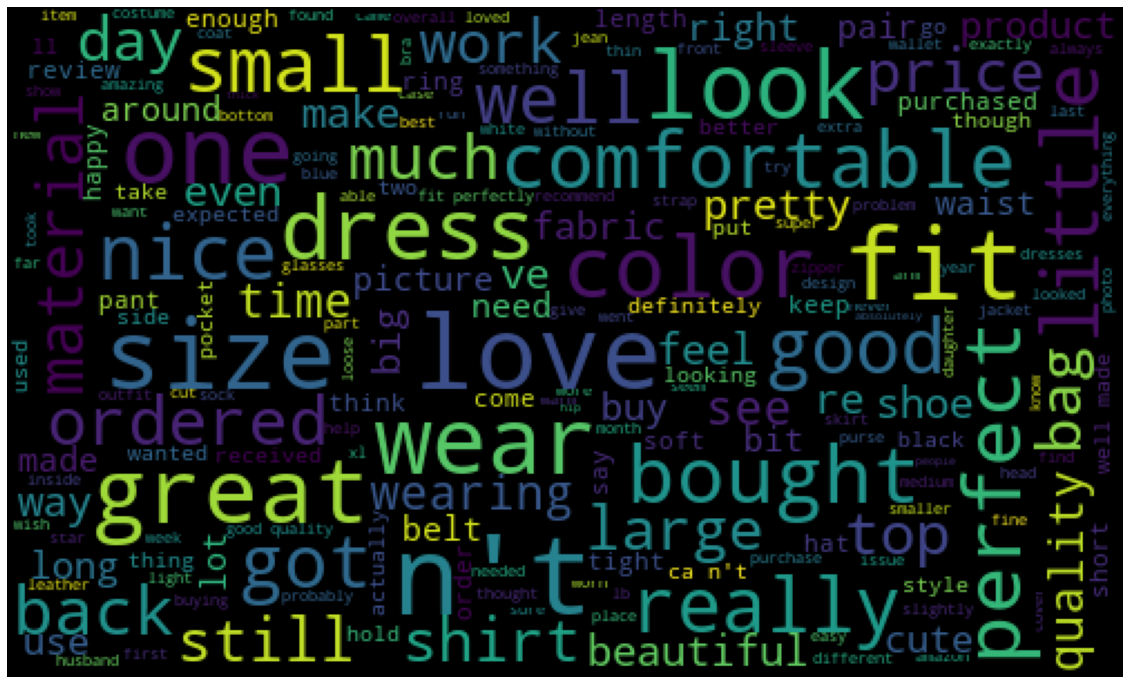

In [195]:
create_word_cloud(brand='Amazon Collection', sentiment=1)

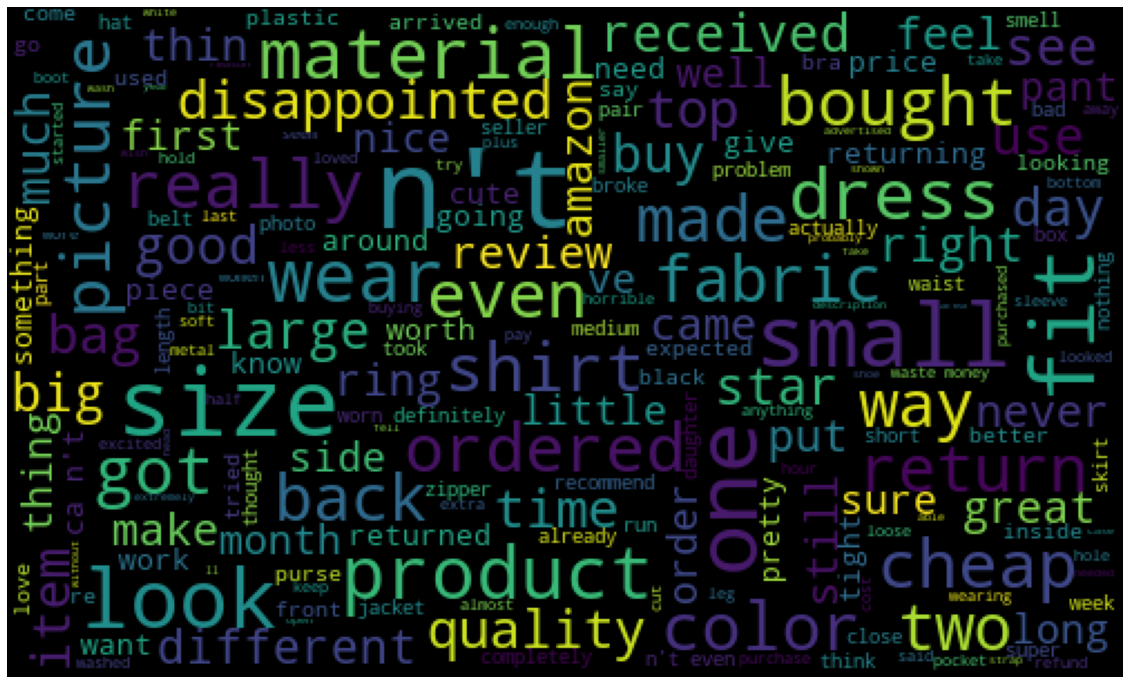

In [196]:
create_word_cloud(brand='Amazon Collection', sentiment=0)

In [176]:
df.Sentiment.value_counts()

1    1868
0     710
Name: Sentiment, dtype: int64

### CountVectorizer with Mulinomial Naive Bayes (Basline Model)

In [197]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 7136 

Show some feature names : 
 ['ab', 'cheapy', 'ends', 'im', 'nicks', 'requires', 'suddenly', 'wonders']


MultinomialNB()

In [198]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [199]:
#Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.8643

AUC score : 0.7710

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.56      0.70        71
           1       0.86      0.98      0.91       187

    accuracy                           0.86       258
   macro avg       0.88      0.77      0.80       258
weighted avg       0.87      0.86      0.85       258


Confusion Matrix : 
 [[ 40  31]
 [  4 183]]


### TfidfVectorizer with Logistic Regression

In [200]:

# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 1959 

Show some feature names : 
 ['00', 'mark']


LogisticRegression()

In [201]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'disappointed' 'small' 'cheap' 'money' 'returning' 'returned'
 'return' 'waste' 'way']

Top 10 features with largest coefficients : 
['love' 'great' 'perfect' 'little' 'well' 'comfortable' 'nice' 'good'
 'beautiful' 'perfectly']


In [202]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.8605

AUC score : 0.7727

Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.58      0.69        71
           1       0.86      0.97      0.91       187

    accuracy                           0.86       258
   macro avg       0.87      0.77      0.80       258
weighted avg       0.86      0.86      0.85       258


Confusion Matrix : 
 [[ 41  30]
 [  6 181]]


### Fine-tuning with Gridsearch

In [204]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuracy on validation set: 0.9031

AUC score : 0.8414

Classification report : 
               precision    recall  f1-score   support

           0       0.93      0.70      0.80        71
           1       0.90      0.98      0.94       187

    accuracy                           0.90       258
   macro avg       0.91      0.84      0.87       258
weighted avg       0.91      0.90      0.90       258


Confusion Matrix : 
 [[ 50  21]
 [  4 183]]


### Word2Vec

In [205]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

2320 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['it', 's', 'pretty', 'big', 'and', 'although', 'i', 'like', 'the', 'ability', 'to', 'get', 'the', 'neckless', 'bigger', 'or', 'smaller', 'i', 'would', 'have', 'like', 'it', 'to', 'be', 'of', 'a', 'different', 'material', 'i', 'had', 'a', 'friend', 'translate', 'what', 'the', 'coin', 'meant', 'ushering', 'in', 'wealth', 'and', 'prosperity', 'idiom', 'and', 'traditional', 'greeting', 'esp', 'at', 'new', 'year', 'interjection', 'edit', 'let', 'riches', 'and', 'treasures', 'come', 'into', 'the', 'house']


In [210]:
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 1237 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['the', 'i', 'and', 'it', 'a', 'to', 'is', 'this', 'for', 'my']


In [244]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [245]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)

Training set : 2320 feature vectors with 300 dimensions
Validation set : 258 feature vectors with 300 dimensions


In [246]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.7791

AUC score : 0.6597

Classification report : 
               precision    recall  f1-score   support

           0       0.67      0.39      0.50        71
           1       0.80      0.93      0.86       187

    accuracy                           0.78       258
   macro avg       0.73      0.66      0.68       258
weighted avg       0.76      0.78      0.76       258


Confusion Matrix : 
 [[ 28  43]
 [ 14 173]]
